王の作ったコード


In [1]:
from urllib import request 
import logging
from pathlib import Path
import numpy as np
import re
import MeCab
import random
from gensim import corpora, models
import pandas as pd
from tqdm import tqdm

# データ読み込み

In [2]:
df_content = pd.read_csv('2019-01-01-content.csv')
df_content['text'] = df_content['text'].replace(np.nan, "", regex=True)
df_content['lang'] = df_content['lang'].replace(np.nan, "", regex=True)
# df_nonna = df_content[df_content['text'].isna() == False]
# df_nonna = df_nonna[df_nonna['lang'].isna() == False]
# len(df_nonna)

In [3]:
# 欠損値の数と割合を求める
def missingval_table(df):
    mv_df = pd.DataFrame(df.isnull().sum())
    mv_df = mv_df.rename(columns={0:'null count'})
    mv_df['null count(%)'] = mv_df['null count']/len(df)*100
    mv_df['variation'] = df.nunique().values
    mv_df['variation(%)'] = df.nunique().values/len(df)*100
    return mv_df

missingval_table(df_content)

,null count,null count(%),variation,variation(%)
Unnamed: 0,0,0.0,8248,100.000000
id,0,0.0,8248,100.000000
text,0,0.0,8206,99.490786
lang,0,0.0,2985,36.190592
article_id,0,0.0,8248,100.000000
likes_count,0,0.0,210,2.546072
tags_str,0,0.0,6119,74.187682
title,0,0.0,8241,99.915131
url,0,0.0,8248,100.000000


# 前処理

In [4]:
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt")
stopwords = [line.decode("utf-8").strip() for line in res]
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt")
stopwords += [line.decode("utf-8").strip() for line in res]

class Tokenizer:
    def __init__(self, stopwords, parser=None, include_pos=None, exclude_posdetail=None, exclude_reg=None):
    
        self.stopwords = stopwords
        self.include_pos = include_pos if include_pos else  ["名詞", "動詞", "形容詞"]
        self.exclude_posdetail = exclude_posdetail if exclude_posdetail else ["接尾", "数"]
        self.exclude_reg = exclude_reg if exclude_reg else r"$^"  # no matching reg
        if parser:
            self.parser = parser
        else:
            mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
            self.parser = mecab.parse
            

    def tokenize(self, text, show_pos=False):
        text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+", "", text)    #URL
        text = re.sub(r"\"?([-a-zA-Z0-9.`?{}]+\.jp)\"?" ,"", text)  # xxx.jp 
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = [
            i[2] if not show_pos else (i[2],i[3]) for i in l 
                if len(i) >=4 # has POS.
                    and i[3].split("-")[0] in self.include_pos
                    and i[3].split("-")[1] not in self.exclude_posdetail
                    and not re.search(r"(-|−)\d", i[2])
                    and not re.search(self.exclude_reg, i[2])
                    and i[2] not in self.stopwords]
        return res

In [5]:
mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
t = Tokenizer(stopwords + ["…。"] , mecab.parse, exclude_reg=r"\d(年|月|日)")

In [6]:
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

['認める', '自分自身', '若さ故の過ち']

In [7]:
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。", show_pos=True)

[('認める', '動詞-自立'), ('自分自身', '名詞-固有名詞-一般'), ('若さ故の過ち', '名詞-固有名詞-一般')]

In [8]:
# doc_path = "./"
# doc_dir = Path(doc_path)
# dirs = [i for i in doc_dir.iterdir() if i.is_dir()]
# dirs

In [9]:
# articles = [a for categ in dirs for a in categ.iterdir()]
# random.shuffle(articles)

# print(articles[:3])
# num_docs = len(articles)
# print("# of docs:", num_docs)

In [10]:
# num_docs = len(articles)
# num_docs

In [11]:
# class Doc_manager():
#     def __init__(self, docs):
#         self.docs = docs
        
#     def read_doc(self, doc_id):
#         with self.docs[doc_id].open() as f:
#             print(f.read())

In [12]:
# dm = Doc_manager(articles)

In [13]:
docs = []
for texts in df_content['text']:
    docs.append(t.tokenize(texts))

In [14]:
docs[0][:10]

['chicken', 'scheme', 'ファイル', 'パス', '動作', 'する', '確認', 'する', 'ん', 'wine']

In [15]:
d = corpora.Dictionary(docs)

In [16]:
print(len(d))
print(d[1289])
print("python id:",d.token2id["python"])
print("C++ id:",d.token2id["C++"])
print(d.doc2bow(["探索","ノード"]))

72990
なくなる
python id: 1433
C++ id: 3875
[(1799, 1), (9579, 1)]


In [17]:
d.filter_extremes(no_below=5, no_above=0.2)
# nob_below以下の個数の単語を無視
# no_aboveの割合以上に出てくる単語を無視
d.compactify()
# idを振り直してコンパクトにする。

In [18]:
dic_num = len(d)
dic_num

14172

In [19]:
d[0]

'CURRENT'

In [20]:
[(d[t[0]],t[1])for t in sorted(d.dfs.items(),key=lambda x:x[1],reverse=True)]

[('データ', 1611),
 ('処理', 1586),
 ('簡単', 1568),
 ('コマンド', 1551),
 ('問題', 1518),
 ('いい', 1514),
 ('情報', 1504),
 ('エラー', 1485),
 ('機能', 1457),
 ('実装', 1433),
 ('内容', 1429),
 ('可能', 1418),
 ('使える', 1397),
 ('取得', 1364),
 ('まとめる', 1350),
 ('入力', 1348),
 ('入れる', 1348),
 ('くれる', 1329),
 ('起動', 1327),
 ('対応', 1316),
 ('部分', 1299),
 ('考える', 1279),
 ('開発', 1251),
 ('値', 1245),
 ('ん', 1239),
 ('いう', 1231),
 ('説明', 1199),
 ('画面', 1193),
 ('出力', 1183),
 ('参照', 1180),
 ('多い', 1178),
 ('言う', 1176),
 ('定義', 1172),
 ('やすい', 1161),
 ('状態', 1159),
 ('しれる', 1152),
 ('最後', 1139),
 ('選択', 1131),
 ('動作', 1121),
 ('アクセス', 1116),
 ('入る', 1110),
 ('関数', 1103),
 ('よい', 1099),
 ('持つ', 1097),
 ('最初', 1095),
 ('バージョン', 1058),
 ('調べる', 1049),
 ('生成', 1044),
 ('読む', 1029),
 ('用意', 1026),
 ('動く', 1000),
 ('手順', 1000),
 ('複数', 957),
 ('デフォルト', 938),
 ('メモ', 937),
 ('保存', 936),
 ('知る', 919),
 ('記述', 918),
 ('以外', 904),
 ('通り', 898),
 ('python', 894),
 ('サイト', 887),
 ('ページ', 886),
 ('()', 880),
 ('便利', 880),
 ('管理', 876),

In [21]:
corpus = [d.doc2bow(w) for w in docs]
test_size = int(len(corpus) * 0.1)
test_corpus = corpus[:test_size]
train_corpus= corpus[test_size:]
print("test size: ", len(test_corpus))
print("train size: ", len(train_corpus))

test size:  824
train size:  7424


# LDAの学習

In [22]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [23]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=d, num_topics=50, passes=10)

using symmetric alpha at 0.02
using symmetric eta at 0.02
using serial LDA version on this node
running online (multi-pass) LDA training, 50 topics, 10 passes over the supplied corpus of 8248 documents, updating model once every 2000 documents, evaluating perplexity every 8248 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #18 (0.020): 0.012*"コマンド" + 0.006*"command" + 0.006*"Left" + 0.006*"起動" + 0.006*"JS" + 0.005*"constraints" + 0.004*"生成" + 0.004*"情報" + 0.004*"Vue" + 0.004*"状態"
topic #7 (0.020): 0.010*"データ" + 0.006*"開発" + 0.006*"処理" + 0.004*"サービス" + 0.004*"アプリ" + 0.004*"入力" + 0.003*"API" + 0.003*"選択" + 0.003*"生成" + 0.003*"起動"
topic #0 (0.020): 0.008*"AND" + 0.006*"出力" + 0.004*"対応" + 0.004*"選択" + 0.003*"PHP" + 0.003*"実装" + 0.003*"データ" + 0.003*"コマンド" + 0.003*"処理" + 0.003*"ログイン"
topic #40 (0.020): 0.008*"ビルド" + 0.007*"遷移" + 0.006*"Zabbix" + 0.005*"手順" + 0.

topic #47 (0.020): 0.018*"コマンド" + 0.016*"bash" + 0.015*"出力" + 0.013*"ALIAS" + 0.013*"置換" + 0.012*"検索" + 0.012*"エクセル" + 0.012*"シェル" + 0.012*"RUST" + 0.010*"EXCEL"
topic #15 (0.020): 0.036*"python" + 0.027*"SLACK" + 0.025*"API" + 0.017*"bot" + 0.016*"取得" + 0.013*"スクリプト" + 0.013*"チャンネル" + 0.012*"Google" + 0.011*"登録" + 0.011*"キャッシュ"
topic #37 (0.020): 0.020*"型" + 0.014*"要素" + 0.009*"配列" + 0.009*"関数" + 0.008*"変数" + 0.008*"JavaScript" + 0.007*"ブロック" + 0.007*"キー" + 0.007*"値" + 0.007*"引数"
topic #12 (0.020): 0.014*"関数" + 0.011*"考える" + 0.010*"表す" + 0.009*"表現" + 0.009*"計算" + 0.008*"条件" + 0.008*"問題" + 0.007*"アルゴリズム" + 0.007*"frac" + 0.006*"制約"
topic diff=1.472086, rho=0.404094
-8.681 per-word bound, 410.4 perplexity estimate based on a held-out corpus of 248 documents with 41820 words
PROGRESS: pass 1, at document #8248/8248
merging changes from 248 documents into a model of 8248 documents
topic #36 (0.020): 0.110*"状態" + 0.064*"イベント" + 0.059*"遷移" + 0.021*"処理" + 0.016*"取得" + 0.014*"ステート" + 0.013*"U

topic #29 (0.020): 0.015*"言う" + 0.013*"考える" + 0.011*"問題" + 0.008*"しれる" + 0.007*"やすい" + 0.007*"多い" + 0.006*"いう" + 0.006*"いい" + 0.006*"プログラム" + 0.005*"プログラミング"
topic diff=0.414079, rho=0.350845
PROGRESS: pass 3, at document #6000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #34 (0.020): 0.023*"Twitter" + 0.021*"英語" + 0.013*"ん" + 0.012*"日本語" + 0.011*"言う" + 0.007*"oci" + 0.007*"よい" + 0.007*"iPhone" + 0.006*"読む" + 0.006*"僕"
topic #8 (0.020): 0.074*"AWS" + 0.026*"S3" + 0.025*"AZURE" + 0.021*"ジョブ" + 0.016*"リソース" + 0.015*"lambda" + 0.015*"選択" + 0.014*"CLOUD" + 0.012*"バケット" + 0.012*"アカウント"
topic #22 (0.020): 0.038*"JS" + 0.028*"Vue" + 0.026*"デプロイ" + 0.015*"web" + 0.013*"node" + 0.013*"開発" + 0.012*"CLI" + 0.012*"コマンド" + 0.012*"app" + 0.011*"Node.js"
topic #46 (0.020): 0.050*"値" + 0.041*"()" + 0.036*"配列" + 0.027*"オブジェクト" + 0.021*"コンポーネント" + 0.021*"要素" + 0.020*"メソッド" + 0.018*"引数" + 0.017*"参照" + 0.016*"変数"
topic #23 (0.020): 0.018*"CLOUD" + 0.017*"監視" + 0.014*"Kuber

topic #13 (0.020): 0.042*"送信" + 0.029*"メッセージ" + 0.023*"受信" + 0.019*"接続" + 0.016*"Raspberry Pi" + 0.015*"フロー" + 0.014*"ラズパイ" + 0.014*"送る" + 0.013*"写真" + 0.013*"デバイス"
topic #14 (0.020): 0.037*"データ" + 0.036*"テーブル" + 0.027*"取得" + 0.025*"データベース" + 0.023*"情報" + 0.019*"API" + 0.017*"db" + 0.016*"SQL" + 0.015*"リクエスト" + 0.014*"id"
topic #0 (0.020): 0.030*"出力" + 0.027*"対応" + 0.027*"java" + 0.017*".S" + 0.015*"サポート" + 0.014*"wordpress" + 0.014*"編集" + 0.014*"9." + 0.012*"echo" + 0.012*"リリース"
topic #38 (0.020): 0.025*"Firefox" + 0.022*"読み込む" + 0.018*"JavaScript" + 0.017*"スクリプト" + 0.017*"pod" + 0.017*"機能" + 0.014*"chrome" + 0.011*"色" + 0.010*"Google Chrome" + 0.010*"QRコード"
topic diff=0.199133, rho=0.314285
PROGRESS: pass 5, at document #4000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #6 (0.020): 0.039*"認証" + 0.023*"id" + 0.022*"key" + 0.018*"トークン" + 0.018*"鍵" + 0.014*"証明書" + 0.013*"情報" + 0.012*"client" + 0.011*"公開鍵" + 0.011*"パスワード"
topic #44 (0.020): 0.018*"UNITY" 

topic diff=0.102077, rho=0.299826
-8.230 per-word bound, 300.3 perplexity estimate based on a held-out corpus of 248 documents with 41820 words
PROGRESS: pass 6, at document #8248/8248
merging changes from 248 documents into a model of 8248 documents
topic #36 (0.020): 0.124*"状態" + 0.072*"イベント" + 0.063*"遷移" + 0.023*"処理" + 0.016*"定義" + 0.013*"ステート" + 0.012*"取得" + 0.010*"UML" + 0.010*"state" + 0.010*"タイミング"
topic #26 (0.020): 0.012*"いい" + 0.010*"勉強" + 0.010*"読む" + 0.009*"チーム" + 0.009*"理解" + 0.009*"内容" + 0.008*"学ぶ" + 0.008*"ふりかえる" + 0.008*"学習" + 0.008*"本"
topic #35 (0.020): 0.116*"テスト" + 0.080*"ユーザー" + 0.026*"メソッド" + 0.024*"アクション" + 0.022*"演習" + 0.018*"ログイン" + 0.016*"メール" + 0.014*"パスワード" + 0.014*"user" + 0.014*"有効"
topic #20 (0.020): 0.137*"データ" + 0.021*"要因" + 0.014*"CSV" + 0.013*"平均" + 0.013*"予測" + 0.012*"モデル" + 0.011*"説明" + 0.011*"用いる" + 0.010*"結合" + 0.010*"変数"
topic #41 (0.020): 0.061*"グループ" + 0.058*"ブロック" + 0.052*"プラグイン" + 0.050*"ノード" + 0.040*"バックアップ" + 0.028*"VPC" + 0.016*"Blockchain

topic #46 (0.020): 0.052*"値" + 0.052*"()" + 0.043*"配列" + 0.034*"オブジェクト" + 0.031*"要素" + 0.030*"引数" + 0.021*"メソッド" + 0.020*"取得" + 0.020*"変数" + 0.018*"参照"
topic #49 (0.020): 0.025*"サービス" + 0.018*"概要" + 0.016*"CLOUD" + 0.015*"ゲート" + 0.013*"制御" + 0.013*"トレーニング" + 0.012*"量子ビット" + 0.010*"可能" + 0.008*"AND" + 0.008*"beta"
topic diff=0.073080, rho=0.276037
PROGRESS: pass 8, at document #8000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #34 (0.020): 0.026*"Twitter" + 0.024*"英語" + 0.019*"日本語" + 0.017*"言う" + 0.015*"ん" + 0.012*"読む" + 0.010*"僕" + 0.009*"tweet" + 0.009*"よい" + 0.009*"いい"
topic #16 (0.020): 0.049*"ダウンロード" + 0.033*"選択" + 0.029*"クリック" + 0.021*"Folder" + 0.016*"手順" + 0.015*"画面" + 0.015*"入力" + 0.012*"保存" + 0.012*"解凍" + 0.011*"pdf"
topic #3 (0.020): 0.040*"GitHub" + 0.032*"開発" + 0.026*"ツール" + 0.026*"リポジトリ" + 0.025*"言語" + 0.023*"git" + 0.021*"ライブラリ" + 0.014*"機能" + 0.014*"FRAMeWORK" + 0.013*"管理"
topic #28 (0.020): 0.114*"ワイ" + 0.049*"Haskell" + 0.037*"flutter" 

In [24]:
def get_topic_words(topic_id):
    for t in lda.get_topic_terms(topic_id):
        print("{}: {}".format(d[t[0]], t[1]))
for t in range(10):
    print("Topic # ",t)
    get_topic_words(t)
    print("\n")

Topic #  0
出力: 0.030644197016954422
対応: 0.025330161675810814
java: 0.022787805646657944
.S: 0.02026606909930706
サポート: 0.01720006763935089
9.: 0.016640324145555496
編集: 0.014705515466630459
echo: 0.014493003487586975
wordpress: 0.01406249962747097
oracle: 0.012243138626217842


Topic #  1
起動: 0.03815783932805061
コマンド: 0.021450836211442947
windows: 0.019351990893483162
python: 0.014779379591345787
パスワード: 0.014713265933096409
Ubuntu: 0.010963677428662777
手順: 0.010816612280905247
入力: 0.010739682242274284
OS: 0.010499861091375351
仮想: 0.00999002531170845


Topic #  2
関数: 0.04743863642215729
出力: 0.01985112577676773
値: 0.016897840425372124
処理: 0.016274143010377884
定義: 0.01565658301115036
計算: 0.013096083886921406
プログラム: 0.010232480242848396
乱数: 0.009529005736112595
変数: 0.009423546493053436
入力: 0.00914160069078207


Topic #  3
GitHub: 0.04318884760141373
開発: 0.02929016761481762
ツール: 0.027524331584572792
言語: 0.02573663741350174
リポジトリ: 0.02487219125032425
git: 0.020507600158452988
ライブラリ: 0.01895823

In [25]:
topics = sorted(lda.get_document_topics(corpus[0]), key=lambda t:t[1], reverse=True)
for t in topics[:10]:
    print("{}: {}".format(t[0], t[1]))

1: 0.23596812784671783
11: 0.19441887736320496
29: 0.13159506022930145
16: 0.11064574122428894
40: 0.08371497690677643
37: 0.05654838681221008
28: 0.05625351518392563
48: 0.04783910512924194
0: 0.04457543417811394
5: 0.02901322767138481


In [26]:
for t in topics[:10]:
    print("Topic # ",t[0])
    get_topic_words(t[0])
    print("\n")

Topic #  1
起動: 0.03815783932805061
コマンド: 0.021450836211442947
windows: 0.019351990893483162
python: 0.014779379591345787
パスワード: 0.014713265933096409
Ubuntu: 0.010963677428662777
手順: 0.010816612280905247
入力: 0.010739682242274284
OS: 0.010499861091375351
仮想: 0.00999002531170845


Topic #  11
開く: 0.030797746032476425
キー: 0.028914930298924446
ウィンドウ: 0.025119785219430923
タブ: 0.022570837289094925
選択: 0.02205369435250759
検索: 0.019991321489214897
入力: 0.017065415158867836
機能: 0.014896226115524769
series: 0.013489275239408016
拡張機能: 0.013280811719596386


Topic #  29
考える: 0.015036568976938725
問題: 0.013501541689038277
言う: 0.01343713141977787
いい: 0.009542752988636494
しれる: 0.00848753098398447
多い: 0.008065175265073776
やすい: 0.007987785153090954
いう: 0.007614087779074907
高い: 0.006279624067246914
可能性: 0.005675008986145258


Topic #  16
ダウンロード: 0.045501213520765305
選択: 0.03168471157550812
クリック: 0.025622550398111343
Folder: 0.022570159286260605
画面: 0.016645284369587898
pdf: 0.01499405037611723
手順: 0.014695

In [27]:
df_content['text'][0]

'Chicken Schemeがファイルパス関係でどう動作するか確認したかったんだけど、Wineを使ううえで少しだけ手間取ったのでメモ。Mac上で動作するWineにはいくつか種類があるようなのだが、今回は日本語に対応しているというEasyWineをインストールした。ちなみにNihonshuとゆうのはよく分からないのでインストールしてない。これを起動するとファイルエクスプローラみたいなのが立ち上がる。ここから試しにC:\\windows\\system32\\cmd.exeを起動してみたが、これが全くキー入力を受け付けない。なので、ConEmuというターミナルソフトをインストール。インストールは普通にFinderからインストーラのファイルを開けばEasyWineが実行してくれる。初期状態ではフォントが可変ピッチで表示が崩れていたので、Andale Monoとゆうフォントに変更した。キー入力の反応がもたつくがそれ以外は普通に動作する。Chicken Schemeはコンパイルにgccを使うので、一応MinGWもインストール。なぜかSourceForgeからだとインストーラがダウンロードできなかったので、OSDNの方を利用した。   環境変数PATHの設定にはC:\\windows\\regedit.exeを使用した。キーの場所はHKEY_CURRENT_USER\\Environment。ちなみにフォントのカスタマイズはHKEY_CURRENT_USER\\Software\\Wine\\Fonts\\Replacements。最後蛇足だが、俺が昔作ったフリーソフトを実行してみたところ全部正常に動作した。すげーなEasyWine。いじょう'

In [28]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)
print(all_topics[0])

[(0, 0.04451054), (1, 0.23581412), (2, 0.00023568759), (3, 0.00023568759), (4, 0.00023568759), (5, 0.029296452), (6, 0.00023568759), (7, 0.00023568759), (8, 0.00023568759), (9, 0.00023568759), (10, 0.00023568759), (11, 0.19441703), (12, 0.00023568759), (13, 0.00023568759), (14, 0.00023568759), (15, 0.00023568759), (16, 0.11068484), (17, 0.00023568759), (18, 0.00023568759), (19, 0.00023568759), (20, 0.00023568759), (21, 0.00023568759), (22, 0.00023568759), (23, 0.00023568759), (24, 0.00023568759), (25, 0.00023568759), (26, 0.00023568759), (27, 0.00023568759), (28, 0.05624854), (29, 0.13162272), (30, 0.00023568759), (31, 0.00023568759), (32, 0.00023568759), (33, 0.00023568759), (34, 0.00023568759), (35, 0.00023568759), (36, 0.00023568759), (37, 0.05646647), (38, 0.00023568759), (39, 0.00023568759), (40, 0.083667204), (41, 0.00023568759), (42, 0.00023568759), (43, 0.00023568759), (44, 0.00023568759), (45, 0.00023568759), (46, 0.00023568759), (47, 0.00023568759), (48, 0.04784458), (49, 0.0

# perplexity

In [29]:
N = sum(count for doc in test_corpus for id, count in doc)
print("N: ",N)

N:  133296


In [30]:
lda.log_perplexity(test_corpus)

-9.466 per-word bound, 707.1 perplexity estimate based on a held-out corpus of 824 documents with 133296 words


-9.465735522215088

In [31]:
bound = lda.bound(test_corpus)/N
bound

-9.465744912398698

In [32]:
perplexity = np.exp2(-lda.log_perplexity(test_corpus))

-9.466 per-word bound, 707.1 perplexity estimate based on a held-out corpus of 824 documents with 133296 words


In [33]:
print("perplexity:", perplexity)

perplexity: 707.0755988290795


# 可視化

In [34]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)

In [35]:
all_topics[1][0]

(0, 0.00032312062)

In [36]:
with open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")

In [37]:
tags_str = df_content["tags_str"]

lang_s = []
for lang in tags_str:
    lang_s.append(lang.split(",")[0])
len(lang_s)

8248

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codelang = le.fit_transform(lang_s)
len(codelang)

8248

In [39]:
with open('doc_lda_metadata.tsv','w',encoding='utf-8-sig') as w:
    w.write('Titles\tGenres\n')    
    for i in range(len(lang_s)):       
        w.write("%s\t%s\n" % (lang_s[i],codelang[i]))

# 類似度

In [40]:
doc_topics = np.array([lda[c] for c in corpus])

In [41]:
doc_topics.shape

(8248, 50, 2)

In [42]:
features = np.zeros( (len(doc_topics), 50), float)

for doc_id, t in enumerate(doc_topics):
    for topic_id, weight in t:
        features[doc_id, int(topic_id)] = weight

In [43]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(features, metric="cosine"))

In [44]:
def similar_to(doc_id, num=5, distance=False):
    doc = pairwise[doc_id]
    ids = np.argsort(doc)[1: num+1] # the most similar is self.
    if distance:
        dist = np.sort(doc)[1: num+1]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

In [45]:
similar_to(0, num=10, distance=True)

[(5808, 0.12783578084160696),
 (870, 0.13111648024281053),
 (153, 0.13592271037900605),
 (6048, 0.16157918424000062),
 (5776, 0.17234649139954528),
 (4718, 0.1809188315395336),
 (5028, 0.19034019226934562),
 (177, 0.19199735003040685),
 (6389, 0.19368643106656203),
 (5645, 0.19500692312914358)]

In [46]:
from gensim import similarities
doc_index = similarities.docsim.MatrixSimilarity(lda[corpus])

scanning corpus to determine the number of features (consider setting `num_features` explicitly)
creating matrix with 8248 documents and 50 features


In [47]:
len(doc_index)

8248

In [48]:
c = corpus[0]
vec_lda = lda[c]
vec_lda

[(0, 0.044553515),
 (1, 0.2358224),
 (2, 0.00023568759),
 (3, 0.00023568759),
 (4, 0.00023568759),
 (5, 0.029177114),
 (6, 0.00023568759),
 (7, 0.00023568759),
 (8, 0.00023568759),
 (9, 0.00023568759),
 (10, 0.00023568759),
 (11, 0.1944243),
 (12, 0.00023568759),
 (13, 0.00023568759),
 (14, 0.00023568759),
 (15, 0.00023568759),
 (16, 0.11069262),
 (17, 0.00023568759),
 (18, 0.00023568759),
 (19, 0.00023568759),
 (20, 0.00023568759),
 (21, 0.00023568759),
 (22, 0.00023568759),
 (23, 0.00023568759),
 (24, 0.00023568759),
 (25, 0.00023568759),
 (26, 0.00023568759),
 (27, 0.00023568759),
 (28, 0.056251653),
 (29, 0.13160779),
 (30, 0.00023568759),
 (31, 0.00023568759),
 (32, 0.00023568759),
 (33, 0.00023568759),
 (34, 0.00023568759),
 (35, 0.00023568759),
 (36, 0.00023568759),
 (37, 0.056503348),
 (38, 0.00023568759),
 (39, 0.00023568759),
 (40, 0.08369448),
 (41, 0.00023568759),
 (42, 0.00023568759),
 (43, 0.00023568759),
 (44, 0.00023568759),
 (45, 0.00023568759),
 (46, 0.00023568759),
 

In [49]:
s = doc_index.__getitem__(vec_lda)

In [50]:
s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)

In [51]:
s[:15]

[(0, 1.0),
 (5808, 0.8721143),
 (870, 0.86883855),
 (153, 0.86401135),
 (6048, 0.838372),
 (5776, 0.82764846),
 (4718, 0.8190871),
 (5028, 0.80956393),
 (177, 0.80796593),
 (6389, 0.8062343),
 (5645, 0.8049413),
 (615, 0.804376),
 (6774, 0.80286723),
 (6657, 0.79673624),
 (1581, 0.7838342)]

In [52]:
for doc_id, sim in s[1:5]:
        print("#", doc_id)
        print(df_content['tags_str'][doc_id])
        print(df_content['text'][doc_id])
        print("===========")

# 5808
CentOS,VirtualBox,ScientificLinux
本件の問題はVirtualBox 6.0.6で解消されたようです。インストールウィザードでマウスカーソルが表示されない2018年12月に、VirtualBoxの新バージョンである6.0.0が公開されました。しかし、これで作成した仮想マシンにCentOS 7をインストールしようとすると、図1のようなGUIによるインストールウィザードでマウスカーソルが表示されないという入門者殺しな状況になっています。この現象はWindows版とLinux版の両方で発生することを筆者自身が確認しており、またmacOS版の利用者からも同じ現象を訴える声を聞いていますので、ホストOSの種別は関係ないようです。カーソルを視認することはできませんが、マウスドライバーの機能自体が壊れているわけではなく、適当なところでマウスをクリックすると「見えないカーソル」がポイントしていた場所がちゃんと反応はします。また、キーボード操作のみでダイアログなどを操作をすることも可能ではあります。ただ、そこまでしてまでインストールを継続しようとするのは単なる苦行でしかありません。ここで記す改善方法を実施して、マウスカーソルが表示されるように改善を図りましょう。図1準備まずは仮想マシンのシャットダウン改善方法を実施するためには、仮想マシンをシャットダウンしておく必要があります。図1の状態で正常なシャットダウン手順を踏むことにも窮してしまったのならば、仮想マシンウィンドウの×ボタンをクリックし、「仮想マシンの電源オフ」を選択して強引にシャットダウンしてしまいましょう。どの道、新規にOSインストールするわけですから、仮想ハードディスクの内容が破損しても問題ないはずです。仮想マシンをシャットダウンしたら、VirtualBoxマネージャーで当該仮想マシンを選択して設定ボタンをクリックし、設定画面を表示します。改善方法以下、改善方法を2つ記します。どちらか一方のみでも改善は可能です。ポインティングデバイスを変更する1つ目の改善方法は、ポインティングデバイスをPS/2 マウスからUSBタブレットに変更することです。設定画面の左ペインでシステムを選択し、図2の赤枠部分の設定を変更します。この方法を選択した場合、OSのインストール中であってもホストOSと

## tagについて調べてみる

[(0, 0.9999999), (5808, 0.87214947), (870, 0.86886513), (153, 0.86403084), (6048, 0.838367), (5776, 0.82763404), (4718, 0.8190965), (5028, 0.80967396), (177, 0.8079905), (6389, 0.8063382), (5645, 0.8049691), (615, 0.80436224), (6774, 0.8028646), (6657, 0.7967275), (1581, 0.7838252)]


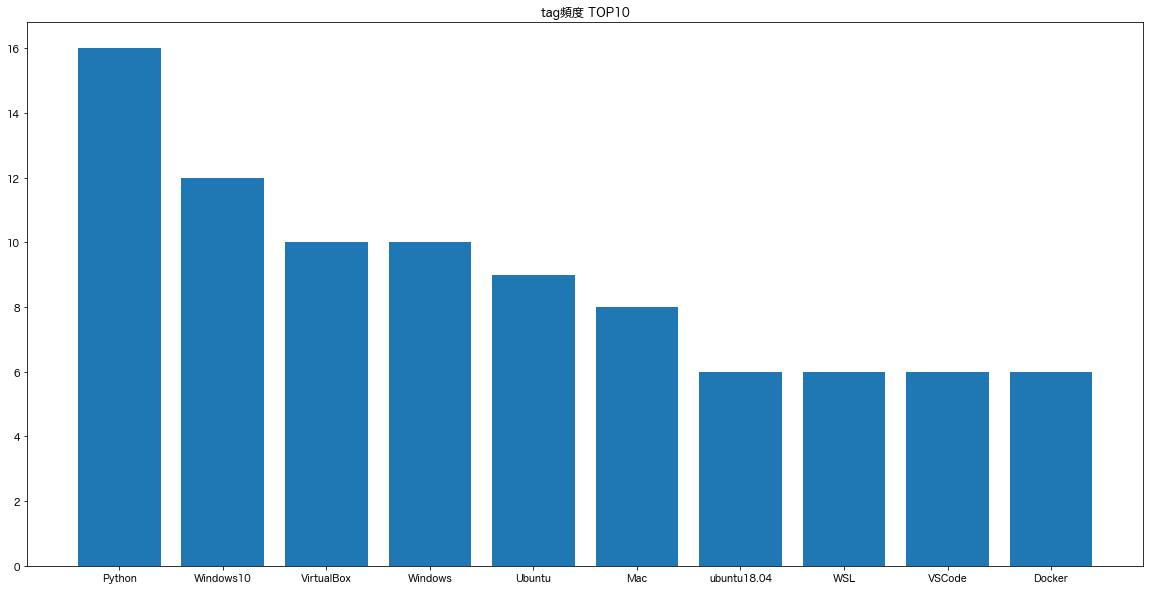

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


def check_tag(index):
    c = corpus[index]
    vec_lda = lda[c]

    s = doc_index.__getitem__(vec_lda)
    s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)
    
    print(s[:15])
    
    
    frequency = Counter()
    
    for doc_id, sim in s[1:100]:
        tags = df_content['tags_str'][doc_id]
        frequency.update(tags.split(','))
        
    # TOP20のグラフ           
    x = range(10)
    mc = frequency.most_common(10)              # 頻度TOP20を抽出
    ch = [ch[0] for ch in mc]           # ひらがなのリスト
    f = np.array([ch[1] for ch in mc])  # 頻度の数値のリスト


    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    ax.bar(x, f)
    ax.set_xticks(x)
    ax.set_xticklabels(ch , fontsize=10)  #日本語表示はfontproperties=fp
    ax.set_title("tag頻度 TOP10")

    plt.show()
    
    
check_tag(0)

[(10, 1.0), (6859, 0.91018915), (7858, 0.9038817), (4605, 0.8982532), (6083, 0.8890313), (6909, 0.8866183), (6008, 0.8858179), (391, 0.8814046), (7011, 0.8774685), (4303, 0.86917657), (3000, 0.8685687), (5749, 0.86321324), (366, 0.86319965), (2915, 0.86223286), (2526, 0.8612357)]


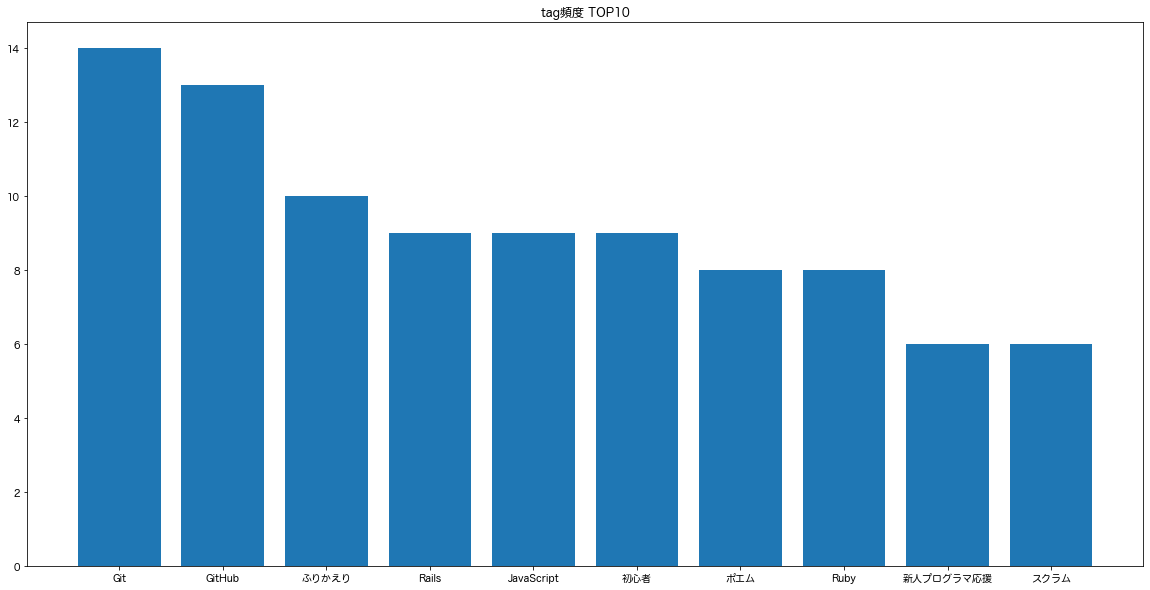

In [54]:
check_tag(10)

# 保存

In [55]:
d.save_as_text("data/dict.txt")
corpora.MmCorpus.serialize("data/cop.mm", corpus)
lda.save("data/lda.model")
doc_index.save("data/sim")

saving dictionary mapping to data/dict.txt
storing corpus in Matrix Market format to data/cop.mm
saving sparse matrix to data/cop.mm
PROGRESS: saving document #0
PROGRESS: saving document #1000
PROGRESS: saving document #2000
PROGRESS: saving document #3000
PROGRESS: saving document #4000
PROGRESS: saving document #5000
PROGRESS: saving document #6000
PROGRESS: saving document #7000
PROGRESS: saving document #8000
saved 8248x14172 matrix, density=0.569% (665655/116890656)
saving MmCorpus index to data/cop.mm.index
saving LdaState object under data/lda.model.state, separately None
saved data/lda.model.state
saving LdaModel object under data/lda.model, separately ['expElogbeta', 'sstats']
storing np array 'expElogbeta' to data/lda.model.expElogbeta.npy
not storing attribute state
not storing attribute dispatcher
not storing attribute id2word
saved data/lda.model
saving MatrixSimilarity object under data/sim, separately None
saved data/sim


In [56]:
from gensim import models, corpora, similarities

corpus = corpora.MmCorpus("data/cop.mm")
lda = models.ldamodel.LdaModel.load("data/lda.model")
d = corpora.Dictionary.load_from_text("data/dict.txt")
doc_index = similarities.docsim.MatrixSimilarity.load("data/sim")

loaded corpus index from data/cop.mm.index
initializing cython corpus reader from data/cop.mm
accepted corpus with 8248 documents, 14172 features, 665655 non-zero entries
loading LdaModel object from data/lda.model
loading expElogbeta from data/lda.model.expElogbeta.npy with mmap=None
setting ignored attribute state to None
setting ignored attribute dispatcher to None
setting ignored attribute id2word to None
loaded data/lda.model
loading LdaState object from data/lda.model.state
loaded data/lda.model.state
loading MatrixSimilarity object from data/sim
loaded data/sim


In [57]:
doc_index.__getitem__(lda[corpus[0]])

array([0.99999994, 0.06127707, 0.22967857, ..., 0.01104797, 0.01061138,
       0.25170735], dtype=float32)